In [25]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

In [26]:
vocab_size = 256
x_ = list(map(ord,"hello"))
y_ = list(map(ord,"hola"))

In [27]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs, targets):
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        outputs = []
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            
            projection = self.project(decoder_output)
            outputs.append(projection)
            decoder_input = torch.LongTensor([targets[i]])
        outputs = torch.stack(outputs).squeeze()
        return outputs
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [32]:
seq2seq = Seq2Seq(vocab_size, 16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [33]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i%100 == 0:
        print("반복 : %d, 오차 : %s", i, loss_val.item())
        _, top1 = prediction.data.topk(1,1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])

반복 : %d, 오차 : %s 0 5.624380588531494
['®', '\x00', '§', 'Ò']
반복 : %d, 오차 : %s 100 2.0791501998901367
['h', 'a', 'a', 'a']
반복 : %d, 오차 : %s 200 1.0187588930130005
['h', 'o', 'l', 'a']
반복 : %d, 오차 : %s 300 0.5358240604400635
['h', 'o', 'l', 'a']
반복 : %d, 오차 : %s 400 0.3044312298297882
['h', 'o', 'l', 'a']
반복 : %d, 오차 : %s 500 0.20887190103530884
['h', 'o', 'l', 'a']
반복 : %d, 오차 : %s 600 0.1553737372159958
['h', 'o', 'l', 'a']
반복 : %d, 오차 : %s 700 0.12098316848278046
['h', 'o', 'l', 'a']
반복 : %d, 오차 : %s 800 0.09549058973789215
['h', 'o', 'l', 'a']
반복 : %d, 오차 : %s 900 0.06996921449899673
['h', 'o', 'l', 'a']


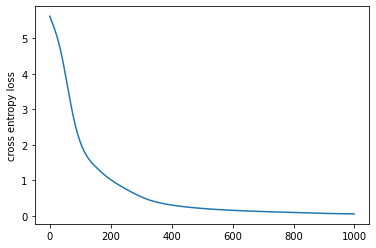

In [34]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()